In [53]:
from glob import glob
import os
from collections import Counter

import rdkit
from rdkit.Chem import AllChem
import pandas as pd

In [57]:
def bond_list_to_smarts(mol, bond_list):
    """For a given molecule and list of bond indices, return a SMARTS string.
    mol: rdkit.Chem.Mol
        The molecule the atom is present in
    bond_list: list
        A list of bond indicies
    """
    atoms = set()
    for bidx in bond_list:
        atoms.add(mol.GetBondWithIdx(bidx).GetBeginAtomIdx())
        atoms.add(mol.GetBondWithIdx(bidx).GetEndAtomIdx())
        
    assert atoms, f"issue with {rdkit.Chem.MolToSmiles(mol)}"
        
    return rdkit.Chem.MolFragmentToSmiles(mol, atoms, canonical=True,
                                          allBondsExplicit=True, allHsExplicit=True)


def radical_center_smarts(row, n=1):
    mol = rdkit.Chem.AddHs(rdkit.Chem.MolFromSmiles(row.SMILES))
    bond_list = AllChem.FindAtomEnvironmentOfRadiusN(mol, n, row.radical_idx, useHs=True)
    return bond_list_to_smarts(mol, bond_list)

In [78]:
radicals = pd.read_csv('all_stable_initial_smiles.csv')

def process(x):
    mol = rdkit.Chem.MolFromSmiles(x)
    charge = sum((abs(atom.GetFormalCharge()) for atom in mol.GetAtoms()))
    for atom in mol.GetAtoms():
        if atom.GetNumRadicalElectrons() == 1:
            radical_idx = atom.GetIdx()
            symbol = atom.GetSymbol()
            break            
    else:
        radical_idx = None
        symbol = None
        
    return pd.Series({'charge': charge,
                      'radical_idx': radical_idx,
                      'symbol': symbol,
                      'num_atoms': mol.GetNumAtoms()})

radicals2 = radicals.join(radicals.SMILES.apply(process))
neutral_radicals = radicals2[(radicals2.charge == 0) & (radicals2.num_atoms < 20)].reset_index(drop=True)

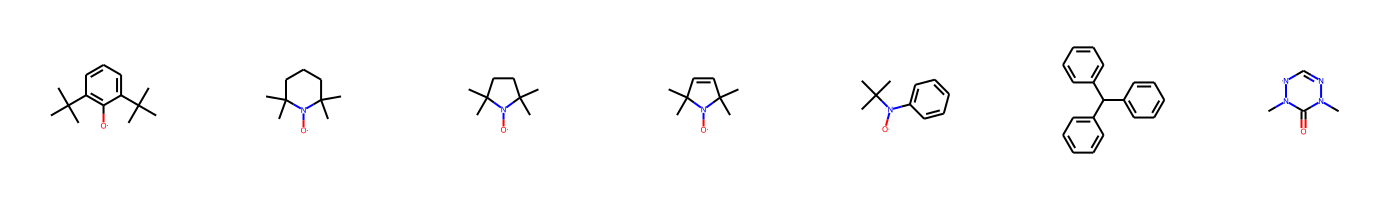

In [82]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage((neutral_radicals.SMILES.apply(rdkit.Chem.MolFromSmiles)), molsPerRow=7)

In [148]:
neutral_radicals

,SMILES,Name,charge,radical_idx,symbol,num_atoms
0,[O]C1=C(C(C)(C)C)C=CC=C1C(C)(C)C,phenoxyl_1,0,0,O,15
1,CC1(C)CCCC(C)(C)N1[O],tempo,0,10,O,11
2,CC1(C)CCC(C)(C)N1[O],proxyl,0,9,O,10
3,CC1(C)C=CC(C)(C)N1[O],s-proxyl,0,9,O,10
4,[O]N(C(C)(C)C)C1=CC=CC=C1,t-ban,0,0,O,12
5,[C](C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,trityl,0,0,C,19
6,CN1[N]C=NN(C)C1=O,verdazyl,0,2,N,9


In [186]:
substruct_smarts = pd.Series(dict(
    phenoxy = '[c](-[C]):[cR1](-[OX1]):[c]-[C]',
    tempo = 'C-[NR1](-[OX1])-C',
    t_ban = 'C-N(-[OX1])-c',
    verdazyl = '[NR1]-[NX2v2]-[CR1]=[NR1]'
))

In [187]:
# assert rdkit.Chem.MolFromSmiles('[O]C1=C(C(C)(C)C)C=CC=C1C(C)(C)C').HasSubstructMatch(rdkit.Chem.MolFromSmarts(phenoxy))
# assert rdkit.Chem.MolFromSmiles('CC1(C)CCC(C)(C)N1[O]').HasSubstructMatch(rdkit.Chem.MolFromSmarts(tempo))
# assert rdkit.Chem.MolFromSmiles('[O]N(C(C)(C)C)C1=CC=CC=C1').HasSubstructMatch(rdkit.Chem.MolFromSmarts(t_ban))
# assert rdkit.Chem.MolFromSmiles('CN1[N]C=NN(C)C1=O').HasSubstructMatch(rdkit.Chem.MolFromSmarts(verdazyl))

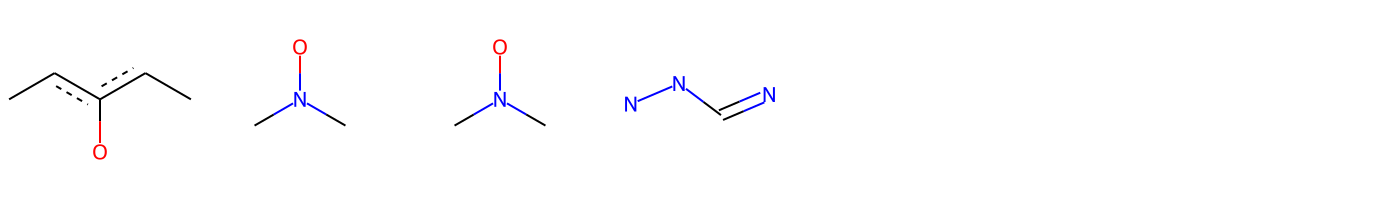

In [188]:
MolsToGridImage(substruct_smarts.apply(rdkit.Chem.MolFromSmarts), molsPerRow=7)

In [189]:
# run_id = 'stable_radical_optimization'
from rlmolecule.sql.run_config import RunConfig
run_config = RunConfig('../config/config_eagle_c.yaml')
run_config.run_id

'stable_rad_c_large'

In [92]:
engine = run_config.start_engine()

In [93]:
# load the games played
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
Session.configure(bind=engine)
session = Session()

df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_config.run_id).statement, session.bind)
df_data = pd.DataFrame(df_rewards.data.tolist())
df_rewards = df_rewards.join(df_data)
df_rewards = df_rewards.dropna()
df_rewards.shape

In [103]:
from tqdm import tqdm
tqdm.pandas()

In [190]:
substructs = substruct_smarts.apply(rdkit.Chem.MolFromSmarts)

In [193]:
def check_stable_substruct(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    return substructs.apply(lambda x: mol.HasSubstructMatch(x))

In [194]:
df_rewards.head().smiles.apply(check_stable_substruct)

,phenoxy,tempo,t_ban,verdazyl
52,False,False,False,False
53,False,False,False,False
54,False,False,False,False
55,False,False,False,False
56,False,False,False,False


In [195]:
matches = df_rewards.smiles.progress_apply(check_stable_substruct)

 66%|██████▌   | 4414836/6710106 [17:32<09:02, 4231.53it/s]  RDKit WARNING: [15:25:34] Conflicting single bond directions around double bond at index 6.
RDKit WARNING: [15:25:34]   BondStereo set to STEREONONE and single bond directions set to NONE.
 66%|██████▌   | 4421293/6710106 [17:34<08:55, 4273.97it/s]RDKit WARNING: [15:25:35] Conflicting single bond directions around double bond at index 6.
RDKit WARNING: [15:25:35]   BondStereo set to STEREONONE and single bond directions set to NONE.
100%|██████████| 6710106/6710106 [30:47<00:00, 3632.95it/s] 


In [196]:
matches.sum(0)

phenoxy     5312
tempo       7790
t_ban       2542
verdazyl     191
dtype: int64

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [200]:
df_rewards.electron_affinity = df_rewards.electron_affinity.astype(float)
df_rewards.ionization_energy = df_rewards.ionization_energy.astype(float)

In [284]:
matched_rows = df_rewards[matches.any(1)].copy().reset_index(drop=True)

matched_rows['substruct'] = matches.columns[np.where(matches.values)[1]]
matched_rows['spin_buried_vol'] = matched_rows.spin_buried_vol.astype(float)
matched_rows['max_spin'] = matched_rows.max_spin.astype(float)
matched_rows['num_atoms'] = matched_rows.smiles.apply(lambda x: rdkit.Chem.MolFromSmiles(x).GetNumAtoms())

In [285]:
matched_rows.groupby('substruct').reward.max()

substruct
phenoxy     193.572424
t_ban       189.048140
tempo       203.190970
verdazyl    198.869725
Name: reward, dtype: float64

In [303]:
to_plot.to_csv('possible_hits.csv', index=False)

In [296]:
to_plot = matched_rows[matched_rows.reward > 180].sort_values(['num_atoms', 'reward'], ascending=[True, False])
img = MolsToGridImage(to_plot.smiles.apply(rdkit.Chem.MolFromSmiles), molsPerRow=4, subImgSize=(200,200), 
                      legends=to_plot.apply(lambda x: f'{x.smiles}\n{x.substruct}\n#atoms={x.num_atoms}', 1).values.tolist(), useSVG=True)

/home/pstjohn/mambaforge/envs/rlmol/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


In [299]:
with open('mols.svg', 'wt') as f:
    f.write(img.data)

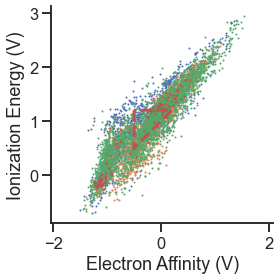

In [237]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.set_adjustable('datalim')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))

for _, subset in matched_rows[(matched_rows.max_spin < 0.5) & (matched_rows.spin_buried_vol > 40)].groupby('substruct'):
    ax.plot(subset.electron_affinity.astype(float), subset.ionization_energy.astype(float), '.', ms=2)

ax.set_xlabel('Electron Affinity (V)')
ax.set_ylabel('Ionization Energy (V)')
# ax.legend()

sns.despine()
fig.tight_layout()

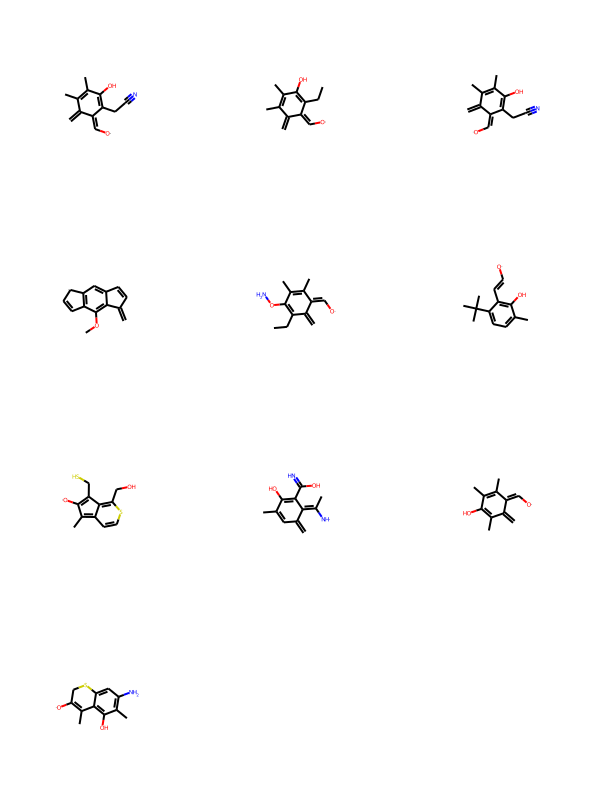

In [144]:
MolsToGridImage(subset.head(10).smiles.apply(rdkit.Chem.MolFromSmiles))